In [1]:
import xgboost as xgb 
from xgboost import XGBClassifier

print(xgb.__version__)

0.90


In [2]:
from xgboost import plot_importance
import pandas as pd 
import numpy as np 
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancel_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancel_df['target']=y_label
cancel_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancel_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [4]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [5]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [6]:
# 하이퍼 파라미터 설정
params = {
    'max_depth' : 3,
    'etc' : 0.1,
    'objective' : 'binary:logistic',
    'eval_metric' : 'logloss',
    'early_stoppings' : 100
}
num_rounds = 400

In [7]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기합니다
wlist = [(dtrain, 'train'), (dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train()함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

ain-logloss:0.126627	eval-logloss:0.174692
[6]	train-logloss:0.103527	eval-logloss:0.155492
[7]	train-logloss:0.085451	eval-logloss:0.133671
[8]	train-logloss:0.072771	eval-logloss:0.124106
[9]	train-logloss:0.06333	eval-logloss:0.116106
[10]	train-logloss:0.054842	eval-logloss:0.107679
[11]	train-logloss:0.04787	eval-logloss:0.100176
[12]	train-logloss:0.043336	eval-logloss:0.097538
[13]	train-logloss:0.037944	eval-logloss:0.089204
[14]	train-logloss:0.033084	eval-logloss:0.092592
[15]	train-logloss:0.029423	eval-logloss:0.09144
[16]	train-logloss:0.026893	eval-logloss:0.090663
[17]	train-logloss:0.024392	eval-logloss:0.090576
[18]	train-logloss:0.022263	eval-logloss:0.088944
[19]	train-logloss:0.02053	eval-logloss:0.086216
[20]	train-logloss:0.018909	eval-logloss:0.086938
[21]	train-logloss:0.017658	eval-logloss:0.084374
[22]	train-logloss:0.016487	eval-logloss:0.080915
[23]	train-logloss:0.015474	eval-logloss:0.084044
[24]	train-logloss:0.014569	eval-logloss:0.082521
[25]	train-logl

In [8]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률값으로 표시됨
[0.978 0.004 0.941 0.048 0.995 1.    1.    1.    0.999 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #f1 스코어 추가
    f1 = f1_score(y_test, pred)
    #AUC 추가
    roc_score = roc_auc_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    #f1 score를 print에 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}\n'
    .format(accuracy, precision, recall, f1,roc_score))

In [10]:
get_clf_eval(y_test, preds)

오차행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1:0.9806, AUC:0.9665



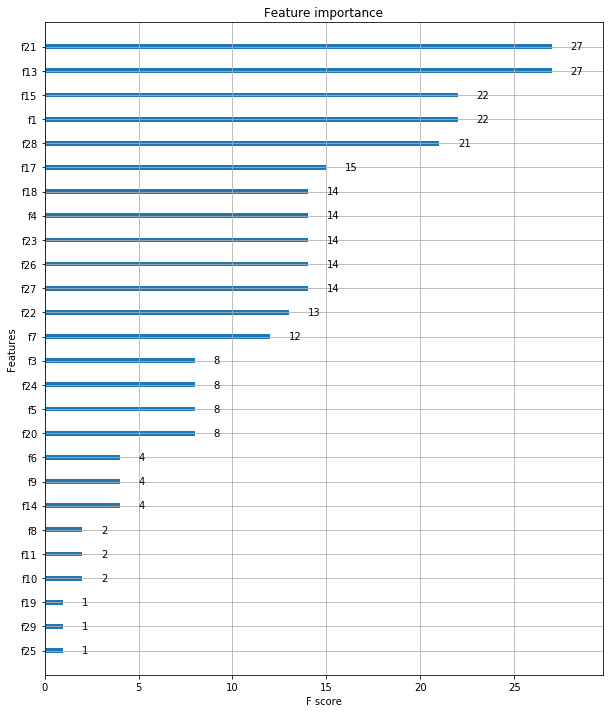

In [11]:
from xgboost import plot_importance
import matplotlib.pyplot as plt 
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

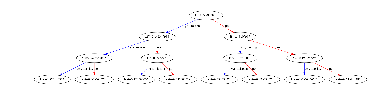

In [12]:
from xgboost import plot_tree

plot_tree(xgb_model)
plt.show()

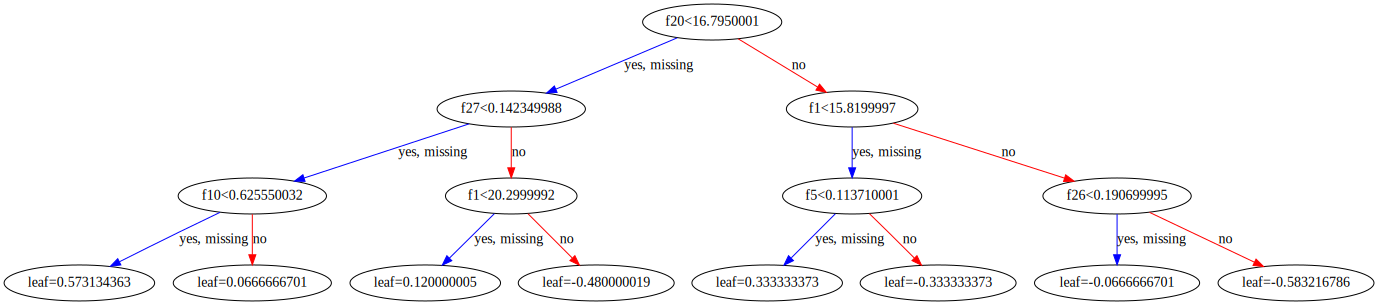

In [13]:
xgb.to_graphviz(xgb_model)